In [1]:
import sys
sys.path.append('..')

In [350]:
import numpy as onp
import jax
import jax.numpy as jnp
import jax.scipy as jsp

import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from scipy import signal as sig

import ceviche_challenges
# import topology.shapes as shapes
import brushes

from itertools import compress
from functools import partial
from math import prod
from ops import convolve_pixel

onp.random.seed(42)

In [150]:
NANOMETERS = ceviche_challenges.units.nm

spec = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_2umx2um_spec(
    wg_width=400 * NANOMETERS,
    variable_region_size=(1600 * NANOMETERS, 1600 * NANOMETERS),
    cladding_permittivity=2.25
)
params = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_sim_params(
    resolution=10 * NANOMETERS,
)
model = ceviche_challenges.waveguide_bend.model.WaveguideBendModel(params, spec)

N = prod(model.design_variable_shape)

# Defining the brush

In [151]:
brush = brushes.notched_square_brush(13, 1)

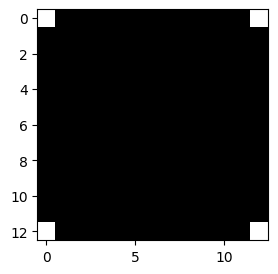

In [152]:
fig = plt.figure(figsize=([3]*2))
plt.imshow(brush, cmap='Greys')
plt.show()

# Step 1 - Defining the initial latent design

In [153]:
# Step 1 - Define initial latent design
scale = 0.01
bias = 0.1
ld = onp.random.randn(*model.design_variable_shape) * scale + bias

# Ensure that the design is fully solid
assert (ld > 0).all()

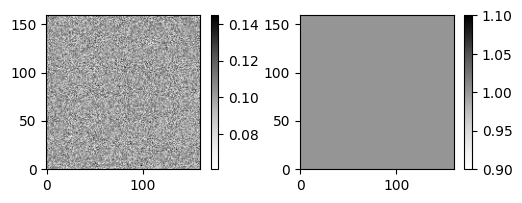

In [154]:
fig, ax = plt.subplots(1,2,figsize=(6,2))
pcm1 = ax[0].imshow(ld.T, cmap='Greys', origin='lower')
fig.colorbar(pcm1, ax=ax[0])#, shrink=0.5)
pcm2 = ax[1].imshow(ld.T > 0, cmap='Greys', origin='lower')
fig.colorbar(pcm2, ax=ax[1])#, shrink=0.5)
plt.show()

# Step 2 - Applying transform

In [155]:
beta = 2 # beta s a scalar hyperparameter in the range 2-8
ld_transformed = jnp.tanh(beta * jsp.signal.convolve2d(ld, brush, mode='same'))
reward = ld_transformed

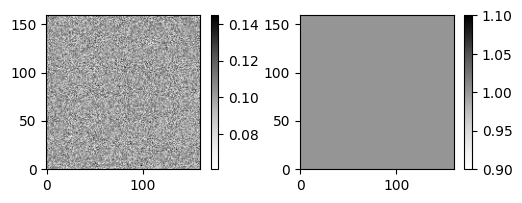

In [156]:
fig, ax = plt.subplots(1,2,figsize=(6,2))
pcm1 = ax[0].imshow(ld.T, cmap='Greys', origin='lower')
fig.colorbar(pcm1, ax=ax[0])#, shrink=0.5)
pcm2 = ax[1].imshow(reward.T, cmap='Greys', origin='lower')
fig.colorbar(pcm2, ax=ax[1])#, shrink=0.5)
plt.show()

# Step 3 - Entry in the conditional generator

### "Greedily" select the best touch as computed from the pixel reward array

In [340]:
# Sort by abs value
# -> If negative: high probability of hole
# -> If positive: high probability of solid
order = onp.argsort(jnp.abs(jsp.signal.convolve2d(reward, brush, mode='same')).flatten())

# Verify that the order indexing is correct
assert jnp.sum(order) == (N-1) * N / 2 # Indexing from 0 -> N-1

In [345]:
# Sort the index
id_sorted = list(zip(*map(lambda x: x.tolist(), jnp.unravel_index(order, reward.shape))))

assert jnp.abs(jsp.signal.convolve2d(reward, brush, mode='same')).max() == np.abs(jsp.signal.convolve2d(reward, brush, mode='same')).flatten()[order[-1]]
assert jnp.abs(jsp.signal.convolve2d(reward, brush, mode='same')).flatten()[order[-1]] == np.abs(jsp.signal.convolve2d(reward, brush, mode='same'))[id_sorted[-1]]
assert jnp.abs(jsp.signal.convolve2d(reward, brush, mode='same')).max() == np.abs(jsp.signal.convolve2d(reward, brush, mode='same'))[id_sorted[-1]]

### Algorithm 1 - Generator for b-feasible designs

In [ ]:
from gruyere.states import FreeState, DesignState
from gruyere.design import Design, _initialize_design

In [ ]:
def _step_generator(des: Design, brush: jnp.array, id_pixel: tuple):

In [367]:
@partial(jax.custom_jvp, nondiff_argnums=(0,))
def conditional_generator(brush, reward):    
    # initialize empty t^s_b and t^v_b
    # touch_s = jnp.zeros_like(reward)
    # touch_v = jnp.zeros_like(reward)
    # x_feasible = jnp.zeros_like(reward)
    feas_design = _initialize_design(reward.shape)
    
    # while design is incomplete do
    while feas_design.x.any() == DesignState.UNASSIGNED:
        # Start from the highest reward
        feas_design = _step_generator(feas_design, brush, id_sorted[-1])
        
        # At the end delete the already made idx using itertools.compress
        # https://stackoverflow.com/questions/10274774/python-elegant-and-efficient-ways-to-mask-a-list
        id_sorted = list(compress(id_sorted, feas_design.x.flatten() == DesignState.UNASSIGNED))
        
# # Update pixel and touch staes
# idx = idx_sorted[-1]
# i, j = idx // reward.shape[0], idx % reward.shape[0]
# touch_s = jax.ops.index_update(touch_s, jax.ops.index[i,j], 1)
# touch_v = jax.ops.index_update(touch_v, jax.ops.index[i,j], 1)
# reward = jax.ops.index_update(reward, jax.ops.index[i,j], 0)
# # Else resovle touch eixts
# reward = jax.ops.index_update(reward, jax.ops.index[i,j], 0)
# # Else select a valid touch
# reward = jax.ops.index_update(reward, jax.ops.index[i,j], 0)

# At the end delete the already made idx using itertools.compress
# https://stackoverflow.com/questions/10274774/python-elegant-and-efficient-ways-to-mask-a-list
# id_sorted = list(compress(id_sorted, x_feasible.flatten() == 0))

### Defining the associated custom derivative

In [368]:
# # TODO: Test the solution of Jax documentation
# # https://jax.readthedocs.io/en/latest/jax-101/04-advanced-autodiff.html
@conditional_generator.defjvp
def conditional_generator_jvp(brush, primals, tangents):
    reward, = primals
    # The gradient of a non-differentiable [is replaced] with that of an estimator
    # A typical estimator [...] is the identity operation.
    # --> The gradient of the identity will be implemented by returning the tangent
    reward_dot, = tangents
    return conditional_generator(brush, reward), reward_dot